<a href="https://colab.research.google.com/github/tayontech/TFH-Analysis/blob/main/tp_secrepo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import re
import requests
import gzip
from io import BytesIO
import ipaddress
import json

urls = [
    "http://www.secrepo.com/self.logs/access.log.2025-01-30.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-01-31.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-01.gz",
    "http://www.secrepo.com/self.logs/access.log.2025-02-02.gz"
]

regex_pattern = r'''(?P<SourceIp>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - (?P<RemoteUser>\S+) \[(?P<TimeLocal>.*?)\] "(?P<Request>.*?)" (?P<Status>\d+) (?P<BodyBytesSent>\d+) "(?P<HttpReferer>.*?)" "(?P<HttpUserAgent>.*?)"'''
compiled_regex = re.compile(regex_pattern)

def extract_groups(text):
    match = compiled_regex.match(text)
    if match:
        return match.groupdict()
    else:
        return {name: None for name in compiled_regex.groupindex}


def process_logs(urls):
    try:
        content = ""
        for url in urls:
            response = requests.get(url, stream=True)
            response.raise_for_status()

            try:
                gzip_file = gzip.GzipFile(fileobj=BytesIO(response.content))
                one_content = gzip_file.read().decode('utf-8')
            except gzip.BadGzipFile:
                one_content = response.content.decode('utf-8')

            content += one_content

        lines = content.splitlines()
        extracted_data = [extract_groups(line) for line in lines]

        df = pd.DataFrame(extracted_data)
        df.replace('-', None, inplace=True)
        df['TimeLocal'] = pd.to_datetime(df['TimeLocal'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
        df.drop('RemoteUser', axis=1, inplace=True)
        df['Status'] = pd.to_numeric(df['Status'], errors='coerce')
        df['BodyBytesSent'] = pd.to_numeric(df['BodyBytesSent'], errors='coerce')
        df['SourceIp'] = df['SourceIp'].apply(lambda ip: str(ipaddress.ip_address(ip)) if ip else None)

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Load data into DataFrame
df = process_logs(urls)
sort = ['TimeLocal', 'SourceIp', 'Request', 'Status', 'BodyBytesSent', 'HttpReferer', 'HttpUserAgent']
df = df[sort]
df.head(10)


,TimeLocal,SourceIp,Request,Status,BodyBytesSent,HttpReferer,HttpUserAgent
0,2025-01-30 00:54:06-08:00,136.227.181.250,GET /DatasetsDescription/Network/weird.html HTTP/1.1,301,495,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
1,2025-01-30 00:54:07-08:00,134.199.68.150,GET /DatasetsDescription/Network/tunnel.html HTTP/1.1,301,497,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
2,2025-01-30 00:54:49-08:00,40.77.167.235,GET /self.logs/error.log.2023-02-28.gz HTTP/1.1,200,1216,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
3,2025-01-30 01:08:07-08:00,223.109.252.201,GET /robots.txt HTTP/1.1,200,340,None,Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
4,2025-01-30 01:08:19-08:00,121.229.156.20,GET / HTTP/1.1,200,13149,None,Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
5,2025-01-30 01:24:23-08:00,52.167.144.229,GET /self.logs/2015/error.log.2015-02-04.gz HTTP/1.1,200,557,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
6,2025-01-30 01:26:16-08:00,61.159.177.37,GET / HTTP/1.1,200,13186,None,"Mozilla/5.0 (Linux; U; Android 13; zh-CN; V2219A Build/TP1A.220624.014) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/100.0.4896.58 UCBrowser/17.3.6.1367 Mobile Safari/537.36"
7,2025-01-30 01:26:17-08:00,61.159.177.37,GET /bootstrap/img/apple-touch-icon.png HTTP/1.1,404,328,http://www.secrepo.com/,"Mozilla/5.0 (Linux; U; Android 13; zh-CN; V2219A Build/TP1A.220624.014) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/100.0.4896.58 UCBrowser/17.3.6.1367 Mobile Safari/537.36"
8,2025-01-30 01:26:17-08:00,61.159.177.37,GET /bootstrap/img/apple-touch-icon-72x72.png HTTP/1.1,404,305,http://www.secrepo.com/,"Mozilla/5.0 (Linux; U; Android 13; zh-CN; V2219A Build/TP1A.220624.014) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/100.0.4896.58 UCBrowser/17.3.6.1367 Mobile Safari/537.36"
9,2025-01-30 01:26:17-08:00,61.159.177.37,GET /bootstrap/img/favicon.ico HTTP/1.1,200,713,http://www.secrepo.com/,"Mozilla/5.0 (Linux; U; Android 13; zh-CN; V2219A Build/TP1A.220624.014) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/100.0.4896.58 UCBrowser/17.3.6.1367 Mobile Safari/537.36"


# Overview of Data

My initial goal was to get a high-level view of the data to identify potential pivot points or surface any obvious issues.

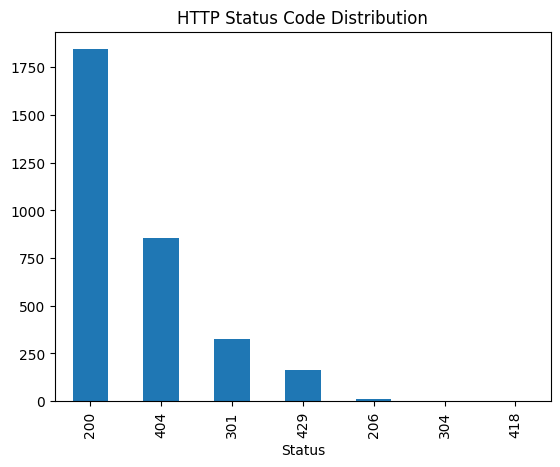

In [17]:
import matplotlib.pyplot as plt

status_counts = df['Status'].value_counts()
status_counts.plot(kind='bar', title='HTTP Status Code Distribution')
plt.show()


In [18]:
enum_attempts = df[df['Status'] == 404]

# Group by SourceIp and UserAgent, then join Requests into one cell
grouped_404 = enum_attempts.groupby(['SourceIp', 'HttpUserAgent']).agg({
    'Request': lambda x: ', '.join(sorted(set(x))),
    'TimeLocal': 'count'
}).rename(columns={'Request': 'Requests', 'TimeLocal': 'Total404s'}).reset_index()

grouped_404 = grouped_404.sort_values('Total404s', ascending=False)
display(grouped_404.head(10))


SourceIp  \
135   152.32.170.13   
174    65.108.41.10   
142  167.172.60.255   
141  167.172.165.51   
202    77.78.225.32   
6     104.28.33.131   
66    149.88.111.79   
62    149.88.111.79   
86    149.88.111.79   
91    149.88.111.79   

                                                                                                                                                                             HttpUserAgent  \
135  Mozilla/5.0 (Linux; Android 11; vivo 1906; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/87.0.4280.141 Mobile Safari/537.36 VivoBrowser/8.9.0.0 uni-app Html5Plus/1.0   
174                                                                                                                       Mozilla/5.0 (compatible; SeekportBot; +https://bot.seekport.com)   
142                               Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36   
141                               Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36   
202                                                                                                                                                                     Go-http-client/1.1   
6                                                                                                                          MobileSafari/8620.2.4.10.7 CFNetwork/3826.400.120 Darwin/24.3.0   
66                                                                          Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36   
62                                                               Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36   
86                                                                                                          Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0   
91                                                                                                          Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:74.0) Gecko/20100101 Firefox/74.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## 404 Error Deep Dive

I noticed there were quite a few `404` errors, so I performed a deep dive on the IP with the most failed requests to understand what was happening.

---

**Source IP:** `152.32.170.13`

**User Agent:**  `Mozilla/5.0 (Linux; Android 11; vivo 1906; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/87.0.4280.141 Mobile Safari/537.36 VivoBrowser/8.9.0.0 uni-app Html5Plus/1.0`



**Key Findings**  
- This source looked for admin consoles and script‑execution entry points:
  - `GET /admin`  
  - `GET /admin/webadmin.php?mod=do&act=login`  
  - `GET /install.inc/vipsignInstall.css`  

- It attempted to interact with multiple backend apis:
  - `POST /api/notice`
  - `POST /Ctrls/GetSysCoin`
  - `POST /km.asmx/getPlatParam`  

- It probed for misconfigured Azure blob sites:
  - `GET /$web/index.html`  

- It fuzzed initialization and API endpoints, these will warrant a closer review:
  - `GET /Public/initJs.php`  
  - `GET /Home/GetInitSource`  
  - `GET /api/api/exchangerateuserconfig!get.action`

  ---
  **Source IP:** `65.108.41.10`

  **User Agent:**  `Mozilla/5.0 (compatible; SeekportBot; +https://bot.seekport.com)`

  **Observations**  
- This appears to be a legitimate crawler, but some requests contain embedded external URLs in the path.  
- Although its 404 volume is low, these malformed paths could indicate log‑file artifact replay or probing for SSRF/open‑redirect bugs.

##Identifying Non 404 Activity
The threat actor did not successfully identify any valid endpoints, this activity appears to be purely enumeration. These IPs will be excluded from any further analysis.

In [19]:
target_ips = [
    '152.32.170.13', '65.108.41.10', '167.172.60.255',
    '167.172.165.51', '77.78.225.32', '149.88.111.79', '104.28.33.131'
]

non_404_activity = df[(df['SourceIp'].isin(target_ips)) & (df['Status'] != 404)]

if not non_404_activity.empty:
    display(non_404_activity[['SourceIp', 'TimeLocal', 'Request', 'Status', 'BodyBytesSent', 'HttpReferer', 'HttpUserAgent']])
else:
    print("No non-404 activity found for the specified IPs.")


,SourceIp,TimeLocal,Request,Status,BodyBytesSent,HttpReferer,HttpUserAgent
339,104.28.33.131,2025-01-30 18:25:30-08:00,GET /favicon.ico HTTP/1.1,200,368,None,MobileSafari/8620.2.4.10.7 CFNetwork/3826.400.120 Darwin/24.3.0
344,104.28.33.131,2025-01-30 18:25:31-08:00,GET /favicon.ico HTTP/1.1,200,368,None,MobileSafari/8620.2.4.10.7 CFNetwork/3826.400.120 Darwin/24.3.0
357,77.78.225.32,2025-01-30 18:49:20-08:00,GET /.git/config HTTP/1.1,301,441,None,Go-http-client/1.1
359,77.78.225.32,2025-01-30 18:49:21-08:00,GET /.env HTTP/1.1,301,427,None,Go-http-client/1.1
361,77.78.225.32,2025-01-30 18:49:21-08:00,GET /config.json HTTP/1.1,301,441,None,Go-http-client/1.1
363,77.78.225.32,2025-01-30 18:49:21-08:00,GET /database.yml HTTP/1.1,301,443,None,Go-http-client/1.1
365,77.78.225.32,2025-01-30 18:49:21-08:00,GET /aws.yml HTTP/1.1,301,433,None,Go-http-client/1.1
367,77.78.225.32,2025-01-30 18:49:22-08:00,GET /aws.json HTTP/1.1,301,435,None,Go-http-client/1.1
369,77.78.225.32,2025-01-30 18:49:22-08:00,GET /firebase.json HTTP/1.1,301,445,None,Go-http-client/1.1
371,77.78.225.32,2025-01-30 18:49:22-08:00,GET /secrets.yml HTTP/1.1,301,441,None,Go-http-client/1.1


## 206 Error Deep Dive (Potential Exfiltration)
This raises a flag for potential data exfiltration activity, possibly through partial downloads from the server.

In [ ]:
dl = df[df['Status'] == 206]
display(dl[[ 'TimeLocal', 'SourceIp', 'Request', 'BodyBytesSent']].sort_values(by='BodyBytesSent', ascending=False))


,TimeLocal,SourceIp,Request,BodyBytesSent
66,2025-01-30 04:50:05-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,110600
68,2025-01-30 04:50:07-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,110600
74,2025-01-30 04:50:24-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,107800
70,2025-01-30 04:50:08-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,107800
72,2025-01-30 04:50:10-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,105000
65,2025-01-30 04:50:05-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
69,2025-01-30 04:50:08-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
67,2025-01-30 04:50:06-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
71,2025-01-30 04:50:10-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447
73,2025-01-30 04:50:24-08:00,85.117.96.24,GET /Security-Data-Analysis/Lab_1/conn.log.zip...,447


There seems to be a successful attempt at exfiltration file `conn.log.zip` from `85.117.96.24`

# 426 Error Code Deep Dive (Potential Bruteforce)

In [20]:
rate_limit_df = df[df['Status'] == 429]

top_429_ips = rate_limit_df['SourceIp'].value_counts().head(10)
display(top_429_ips)

rate_limit_requests = rate_limit_df[['SourceIp', 'TimeLocal', 'Request', 'HttpUserAgent']]
display(rate_limit_requests.head(20))

ips_with_429 = rate_limit_df['SourceIp'].unique()

,count
SourceIp,
100.28.228.64,30
195.78.54.31,15
143.92.34.18,10
57.141.7.1,7
57.141.7.10,5
57.141.7.6,5
57.141.7.15,5
57.141.7.27,4
57.141.7.9,4


,SourceIp,TimeLocal,Request,HttpUserAgent
50,82.165.125.69,2025-01-30 03:55:20-08:00,GET /bitrix/admin/htmleditor2/simple.php HTTP/1.1,"Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36"
51,82.165.125.69,2025-01-30 03:55:23-08:00,GET /simple.php HTTP/1.1,"Mozlila/5.0 (Linux; Android 7.0; SM-G892A Bulid/NRD90M; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/60.0.3112.107 Moblie Safari/537.36"
94,57.141.7.16,2025-01-30 06:26:00-08:00,GET /self.logs/2016/?C=S;O=A HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
98,57.141.7.1,2025-01-30 06:43:47-08:00,GET /self.logs/?C=D;O=A HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
102,57.141.7.6,2025-01-30 07:01:15-08:00,GET /Datasets%20Description/Network/dhcp.html HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
103,57.141.7.10,2025-01-30 07:09:01-08:00,GET /Datasets%20Description/HTML_Bro_log_1/http.html HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
106,57.141.7.2,2025-01-30 07:45:08-08:00,GET /Datasets%20Description/Network/ssl.html HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
109,57.141.7.17,2025-01-30 07:54:37-08:00,GET /self.logs/?C=S;O=D HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
127,57.141.7.10,2025-01-30 09:17:14-08:00,GET /Datasets%20Description/HTML_Bro_log_1/?C=N;O=D HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)
137,57.141.7.9,2025-01-30 10:23:44-08:00,GET /Datasets%20Description/HTML_Bro_log_2/ HTTP/1.1,meta-externalagent/1.1 (+https://developers.facebook.com/docs/sharing/webmasters/crawler)


# Coorelate IPs found in 429 error codes with 200 codes

In [21]:
ips_with_429 = [
    '100.28.228.64', '195.78.54.31', '143.92.34.18',
    '57.141.7.1', '57.141.7.10', '57.141.7.6',
    '57.141.7.15', '57.141.7.27', '57.141.7.9', '57.141.7.8'
]

success_attempts = df[(df['Status'] == 200) & (df['SourceIp'].isin(ips_with_429))]

if not success_attempts.empty:
    display(success_attempts[['SourceIp', 'TimeLocal', 'Request', 'BodyBytesSent', 'HttpUserAgent']])
else:
    print("No successful HTTP 200 responses found.")


No successful HTTP 200 responses found.


# 301 Redirect Deep Dive

In [23]:
redirect_df = df[df['Status'] == 301]
display(redirect_df[['SourceIp', 'TimeLocal', 'Request', 'HttpReferer', 'HttpUserAgent']])


,SourceIp,TimeLocal,Request,HttpReferer,HttpUserAgent
0,136.227.181.250,2025-01-30 00:54:06-08:00,GET /DatasetsDescription/Network/weird.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
1,134.199.68.150,2025-01-30 00:54:07-08:00,GET /DatasetsDescription/Network/tunnel.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
12,203.78.170.218,2025-01-30 01:36:54-08:00,GET /DatasetsDescription/Network/ssh.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
13,103.241.53.85,2025-01-30 01:36:55-08:00,GET /DatasetsDescription/Network/ssl.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
19,220.181.37.152,2025-01-30 02:12:39-08:00,GET / HTTP/1.1,None,"Mozilla/5.0 (Linux; Android 6.0.1; SOV33 Build/35.0.D.0.326) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.91 Mobile Safari/537.36"
24,103.225.130.40,2025-01-30 02:25:54-08:00,GET /DatasetsDescription/Network/signatures.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
25,213.159.13.56,2025-01-30 02:25:55-08:00,GET /DatasetsDescription/Network/smtp.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
26,134.199.92.91,2025-01-30 02:36:54-08:00,GET /DatasetsDescription/Network/notice.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
27,134.199.90.67,2025-01-30 02:36:54-08:00,GET /DatasetsDescription/Network/http.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
29,134.199.95.141,2025-01-30 02:50:24-08:00,GET /DatasetsDescription/Network/files.html HTTP/1.1,None,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"


Review Events Without Httpreferers

In [33]:
df['MissingReferer'] = df['HttpReferer'].isna() | (df['HttpReferer'].str.strip() == '')

missing_referer_df = df[df['MissingReferer']]

top_missing_referer_ips = missing_referer_df['SourceIp'].value_counts().head(10)
display(top_missing_referer_ips)

display(missing_referer_df[['TimeLocal','SourceIp', 'Request', 'Status', 'HttpUserAgent']].head(20))




,count
SourceIp,
149.88.111.79,198
216.244.66.245,59
149.88.111.72,55
167.172.60.255,54
167.172.165.51,50
149.88.111.99,44
51.222.253.17,36
51.222.253.11,36
51.222.253.8,35


,TimeLocal,SourceIp,Request,Status,HttpUserAgent
0,2025-01-30 00:54:06-08:00,136.227.181.250,GET /DatasetsDescription/Network/weird.html HTTP/1.1,301,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
1,2025-01-30 00:54:07-08:00,134.199.68.150,GET /DatasetsDescription/Network/tunnel.html HTTP/1.1,301,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
2,2025-01-30 00:54:49-08:00,40.77.167.235,GET /self.logs/error.log.2023-02-28.gz HTTP/1.1,200,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
3,2025-01-30 01:08:07-08:00,223.109.252.201,GET /robots.txt HTTP/1.1,200,Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
4,2025-01-30 01:08:19-08:00,121.229.156.20,GET / HTTP/1.1,200,Sogou web spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)
5,2025-01-30 01:24:23-08:00,52.167.144.229,GET /self.logs/2015/error.log.2015-02-04.gz HTTP/1.1,200,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
6,2025-01-30 01:26:16-08:00,61.159.177.37,GET / HTTP/1.1,200,"Mozilla/5.0 (Linux; U; Android 13; zh-CN; V2219A Build/TP1A.220624.014) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/100.0.4896.58 UCBrowser/17.3.6.1367 Mobile Safari/537.36"
12,2025-01-30 01:36:54-08:00,203.78.170.218,GET /DatasetsDescription/Network/ssh.html HTTP/1.1,301,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
13,2025-01-30 01:36:55-08:00,103.241.53.85,GET /DatasetsDescription/Network/ssl.html HTTP/1.1,301,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0 Safari/537.36"
14,2025-01-30 01:50:43-08:00,123.182.50.58,GET / HTTP/1.1,200,"Mozilla/5.0 (iPhone; CPU iPhone OS 16_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.2 Mobile/15E148 YisouSpider/5.0 Safari/604.1"


Creating Pivot Table to view codes by ip for 301 redirects

In [34]:
pivot = pd.pivot_table(
    missing_referer_df,
    index='SourceIp',
    columns='Status',
    values='Request',
    aggfunc='count',
    fill_value=0
).sort_values(by=200, ascending=False)  # Prioritize IPs with successful requests

display(pivot.head(10))


Status,200,206,301,304,404,418,429
SourceIp,,,,,,,
216.244.66.245,57,0,2,0,0,0,0
51.222.253.17,36,0,0,0,0,0,0
51.222.253.11,36,0,0,0,0,0,0
51.222.253.8,35,0,0,0,0,0,0
51.222.253.16,34,0,0,0,0,0,0
51.222.253.1,34,0,0,0,0,0,0
51.222.253.10,33,0,0,0,0,0,0
51.222.253.9,32,0,0,0,0,0,0
51.222.253.13,31,0,0,0,0,0,0


Finding Succesful attempts after 301

In [38]:
redirect_ips = df[df['Status'] == 301]['SourceIp'].unique()

success_after_redirect = df[(df['SourceIp'].isin(redirect_ips)) & (df['Status'] == 200)]

# Display suspicious successful access attempts
display(success_after_redirect[['SourceIp', 'TimeLocal', 'Request', 'BodyBytesSent', 'HttpReferer', 'HttpUserAgent']])




,SourceIp,TimeLocal,Request,BodyBytesSent,HttpReferer,HttpUserAgent
18,40.77.167.51,2025-01-30 02:07:08-08:00,GET /self.logs/error.log.2018-08-18.gz HTTP/1.1,6180,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
22,40.77.167.51,2025-01-30 02:16:25-08:00,GET /self.logs/error.log.2017-08-03.gz HTTP/1.1,1112,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
23,52.167.144.137,2025-01-30 02:21:19-08:00,GET /self.logs/2015/access.log.2015-12-24.gz HTTP/1.1,5419,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
37,52.167.144.204,2025-01-30 03:10:18-08:00,GET /self.logs/error.log.2021-09-29.gz HTTP/1.1,2459,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
43,52.167.144.237,2025-01-30 03:43:54-08:00,GET /self.logs/ HTTP/1.1,54549,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
47,52.167.144.231,2025-01-30 03:47:56-08:00,GET /self.logs/access.log.2024-10-07.gz HTTP/1.1,21472,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
49,52.167.144.147,2025-01-30 03:55:10-08:00,GET /self.logs/error.log.2020-08-15 HTTP/1.1,307,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
61,114.119.151.93,2025-01-30 04:37:22-08:00,GET /robots.txt HTTP/1.1,377,None,"Mozilla/5.0 (Linux; Android 7.0;) AppleWebKit/537.36 (KHTML, like Gecko) Mobile Safari/537.36 (compatible; PetalBot;+https://webmaster.petalsearch.com/site/petalbot)"
64,40.77.167.79,2025-01-30 04:49:57-08:00,GET /self.logs/error.log.2021-02-13.gz HTTP/1.1,3579,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
75,40.77.167.50,2025-01-30 04:51:37-08:00,GET /self.logs/error.log.2024-03-09.gz HTTP/1.1,11851,None,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Gecko; compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) Chrome/116.0.1938.76 Safari/537.36"
